In [1]:
#import packages
import numpy as np
import allel;print('scikit-allel',allel.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
import zarr
import urllib
import shutil
from pathlib import Path
import zipfile
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')

import pandas as pd
import h5py
import numcodecs
print('zarr', zarr.__version__,'numcodes', numcodecs.__version__)
import sys

scikit-allel 1.2.1
zarr 2.3.2 numcodes 0.6.3


In [2]:
#set paths to zarr format
zarr_path1 = 'C:/Users/ekattenberg/Documents/Werk_LOCAL/FA4_Vietnam/WGS_analysis/BGI_WGS/PV_filteredPASS_0808.zarr'
chromosomes = ['PvP01_01_v1', 'PvP01_02_v1', 'PvP01_03_v1', 'PvP01_04_v1', 'PvP01_05_v1', 'PvP01_06_v1', 'PvP01_07_v1', 
       'PvP01_08_v1', 'PvP01_09_v1', 'PvP01_10_v1', 'PvP01_11_v1', 'PvP01_12_v1', 'PvP01_13_v1', 'PvP01_14_v1']
chromosomes

['PvP01_01_v1',
 'PvP01_02_v1',
 'PvP01_03_v1',
 'PvP01_04_v1',
 'PvP01_05_v1',
 'PvP01_06_v1',
 'PvP01_07_v1',
 'PvP01_08_v1',
 'PvP01_09_v1',
 'PvP01_10_v1',
 'PvP01_11_v1',
 'PvP01_12_v1',
 'PvP01_13_v1',
 'PvP01_14_v1']

In [3]:
#load zarr filtered file 
callset_clean = zarr.open_group(zarr_path1, mode='r')
callset_clean

<zarr.hierarchy.Group '/' read-only>

In [4]:
#pick a chromosome:
chrom = 'PvP01_14_v1'
#acces variants of chrom 14
variants1=callset_clean[chrom]['variants']
variants1

<zarr.hierarchy.Group '/PvP01_14_v1/variants' read-only>

In [5]:
pos1=allel.SortedIndex(variants1['POS'])
pos1

0,1,2,3,4,...,25781,25782,25783,25784,25785
346,782,898,6967,7959,...,3019190,3019228,3019438,3019465,3019578


In [7]:
#call genotype data for chr 14 and convert to genotype array
calldata1 = callset_clean[chrom]['calldata']
g1 = allel.GenotypeArray(calldata1['GT'])
g1

<GenotypeArray shape=(25786, 43, 2) dtype=int8>
./. 0/0 ./. 0/0 0/0 ... 0/0 0/0 0/0 ./. ./.
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 ./. ./. ./.
0/0 0/0 ./. 0/0 0/0 ... 0/0 0/0 ./. ./. 0/0
...
0/1 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/1 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [8]:
#Extract variants as a chunked table
variants = allel.VariantChunkedTable(callset_clean[chrom]['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD'],
                                     index='POS')
variants

<VariantChunkedTable shape=(25786,) dtype=[('POS', '<i4'), ('REF', 'O'), ('ALT', 'O'), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=805.8K cbytes=306.9K cratio=2.6
   values=zarr.hierarchy.Group>

In [9]:
#Compute the percent of missing and heterozygous genotype calls for each sample.
n_variants = len(variants)
pc_het = g1.count_het(axis=0)[:]*100/n_variants

In [12]:
pc_missinggt = g1.count_missing(axis=1)[:]*100/43
np.argsort(pc_missinggt)[-1]

8097

In [20]:
condition_gtmiss = (pc_missinggt<=30)
condition_gtmiss

array([False, False, False, ...,  True,  True,  True])

In [21]:
#subset gt table to exclude samples with high missingness
g_selected1 = g1.compress(condition_gtmiss,axis=0)
g_selected1

<GenotypeArray shape=(24634, 43, 2) dtype=int8>
0/0 ./. ./. 0/0 0/0 ... ./. 0/0 0/0 0/0 0/0
0/0 ./. ./. 0/0 0/0 ... ./. 0/0 0/0 0/0 ./.
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/1
...
0/1 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/1 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [22]:
pos_filt = pos1.compress(condition_gtmiss,axis=0)
pos_filt

0,1,2,3,4,...,24629,24630,24631,24632,24633
33308,33311,33544,33546,33582,...,3019190,3019228,3019438,3019465,3019578


In [23]:
n_variants1 = len(g_selected1)
pc_missing = g_selected1.count_missing(axis=0)[:]*100/n_variants1

In [32]:
sam = np.array(callset_clean[chrom]['samples'])
sam

array(['CRCPV-007-0a', 'CRCPV-007-35', 'CRCPV-008-0a', 'CRCPV-008-42',
       'CRCPV-010-0a', 'CRCPV-010-35', 'CRCPV-018-0a', 'CRCPV-018-35',
       'CRCPV-022-0a', 'CRCPV-022-42', 'CRCPV-027-0a', 'CRCPV-027-33',
       'CRCPV-034-0a', 'CRCPV-034-42', 'CRCPV-037-0a', 'CRCPV-037-34',
       'CRCPV-043-0a', 'CRCPV-043-35', 'CRCPV-044-0a', 'CRCPV-044-42',
       'CRCPV-047-0a', 'CRCPV-047-43', 'CRCPV-048-0a', 'CRCPV-048-42',
       'CRCPV-053-0b', 'CRCPV-053-42', 'CRCPV-054-0a', 'CRCPV-054-35',
       'Pv-BP-15-16-14', 'Pv-BP-15-16-15', 'Pv-BP-16-11', 'Pv-BP-16-12',
       'Pv-BP-16-16', 'Pv-BP-16-17', 'Pv-BP-16-18-1', 'Pv-BP-16-18-2',
       'Pv-DL-15-10', 'Pv-DL-15-6', 'Pv-DL-15-8', 'Pv-DL-15-9',
       'Pv-DN-16-2', 'Pv-DN-16-5', 'Pv-KH-17-20'], dtype=object)

In [33]:
#step 1 select samples to retain (exclude with high missingness and high chance of recurrence)
list2 = np.array([2, 5, 7, 10, 13, 14, 23, 24, 27])
list1 = np.array(range(0,42))
select_samples = np.setdiff1d(list1,list2)
select_samples

array([ 0,  1,  3,  4,  6,  8,  9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22,
       25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41])

In [34]:
#subset gt table to exclude samples with high missingness
g_selected2 = g_selected1.take(select_samples,axis=1)
g_selected2

<GenotypeArray shape=(24634, 33, 2) dtype=int8>
0/0 ./. 0/0 0/0 ./. ... 0/0 ./. 0/0 0/0 0/0
0/0 ./. 0/0 0/0 ./. ... 0/0 ./. 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/1 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/1 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [35]:
#convert  to number of alternate alleles per call
gn2 = g_selected2.to_n_alt(fill=-1)
gn2

array([[ 0, -1,  0, ...,  0,  0,  0],
       [ 0, -1,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0]], dtype=int8)

In [38]:
#LD pruning
#if we do it with the gn2 table we dont know the positions, so lets try this with a df
GN = pd.DataFrame(gn2,pos_filt)
GN

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
33308,0,-1,0,0,-1,0,0,0,2,0,...,0,0,0,0,0,0,-1,0,0,0
33311,0,-1,0,0,-1,0,0,0,2,0,...,0,0,0,0,0,0,-1,0,0,0
33544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33546,0,0,0,2,0,-1,-1,2,2,2,...,0,2,2,1,1,1,2,-1,1,0
33582,0,0,0,2,0,-1,-1,2,2,2,...,0,1,1,1,1,1,0,-1,1,2
33583,0,0,0,2,0,-1,-1,2,2,2,...,0,1,1,1,1,1,0,-1,1,2
33587,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33703,2,2,1,-1,0,2,1,1,0,2,...,1,1,1,0,1,2,0,0,2,1
33717,1,1,0,-1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-1,0
33737,2,2,0,-1,0,2,1,1,0,2,...,1,1,1,0,1,2,1,0,-1,2


In [39]:
def ld_prune_df(gn, size, step, threshold=.2, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn[loc_unlinked]
    return gn

In [40]:
GNU = ld_prune_df(GN, size=500, step=20, threshold=.2, n_iter=6)

iteration 1 retaining 4908 removing 19726 variants
iteration 2 retaining 3369 removing 1539 variants
iteration 3 retaining 3141 removing 228 variants
iteration 4 retaining 3125 removing 16 variants
iteration 5 retaining 3123 removing 2 variants
iteration 6 retaining 3123 removing 0 variants


In [41]:
#Result: LD pruned gn table
GNU

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
33308,0,-1,0,0,-1,0,0,0,2,0,...,0,0,0,0,0,0,-1,0,0,0
33544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33546,0,0,0,2,0,-1,-1,2,2,2,...,0,2,2,1,1,1,2,-1,1,0
33587,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33703,2,2,1,-1,0,2,1,1,0,2,...,1,1,1,0,1,2,0,0,2,1
33717,1,1,0,-1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-1,0
34658,0,-1,0,0,-1,0,0,0,-1,0,...,0,0,0,0,0,2,0,-1,0,-1
34716,0,-1,0,0,-1,0,0,0,-1,2,...,0,0,0,0,0,-1,0,0,0,-1
34783,0,-1,0,-1,0,0,0,0,0,0,...,-1,0,0,0,0,-1,0,0,0,0
34975,0,0,0,-1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [42]:
#count heterozygotes per variant and recalculate allele freq assuming haploid
hetcount = np.array(g_selected2.count_het(axis=1))
call_count= np.array(g_selected2.count_called(axis=1))
missing_count= np.array(g_selected2.count_missing(axis=1))
hom_count= np.array(g_selected2.count_hom(axis=1))
hom_ref_count= np.array(g_selected2.count_hom_ref(axis=1))
hom_alt_count= np.array(g_selected2.count_hom_alt(axis=1))
AF_alt = pd.DataFrame((hetcount+(hom_alt_count/2))/((2*hetcount)+(hom_count/2)), pos_filt, columns=['AF'])
#AF_alt.to_csv('chrom14_AF.csv')
AF_alt

,AF
33308,0.034483
33311,0.096774
33544,0.000000
33546,0.470588
33582,0.444444
33583,0.444444
33587,0.138889
33703,0.531250
33717,0.285714
33737,0.524590


In [43]:
#Calculate minor allele frequency 
MAF = AF_alt.loc[AF_alt['AF']<= 0.5] 
AF2 = AF_alt.loc[AF_alt['AF']> 0.5]
AFtoMAF = pd.DataFrame((1-AF2))
MAF = MAF.append(AFtoMAF) 
MAF

,AF
33308,0.034483
33311,0.096774
33544,0.000000
33546,0.470588
33582,0.444444
33583,0.444444
33587,0.138889
33717,0.285714
34658,0.038462
34716,0.137931


In [44]:
#combine LE and MAF and select
selection = pd.concat([GNU, MAF], axis=1, join='inner')

#Calculate minor allele frequency 
selection = selection.loc[(selection['AF']>0.1)] 
selection.to_csv('chrom14_select_LD_MAF.csv')
selection


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,AF
33546,0,0,0,2,0,-1,-1,2,2,2,...,2,2,1,1,1,2,-1,1,0,0.470588
33587,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.138889
33703,2,2,1,-1,0,2,1,1,0,2,...,1,1,0,1,2,0,0,2,1,0.468750
33717,1,1,0,-1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,-1,0,0.285714
34716,0,-1,0,0,-1,0,0,0,-1,2,...,0,0,0,0,-1,0,0,0,-1,0.137931
36312,0,2,0,0,0,0,0,0,-1,0,...,0,0,0,1,0,0,0,0,0,0.138889
39539,0,-1,0,0,0,0,0,2,-1,0,...,2,0,-1,1,0,1,2,0,0,0.314286
40345,0,2,0,-1,1,0,0,2,-1,2,...,-1,2,0,1,0,1,0,2,2,0.394737
43289,0,-1,0,2,-1,0,0,2,-1,0,...,0,2,2,0,0,2,0,0,0,0.296296
43459,1,-1,2,2,2,2,2,0,0,0,...,0,2,0,2,2,0,-1,-1,2,0.500000


In [45]:
ac = g_selected2.count_alleles()
ac

<AlleleCountsArray shape=(24634, 2) dtype=int32>
56  2
53  3
60  0
...
57  1
59  1
59  1

In [46]:
#Tajima's D over a window
D, windowsD, countsD = allel.windowed_tajima_d(pos_filt, ac, size=500, step = 250)
D

array([ 1.63923578,  2.14277776,         nan, ..., -1.72792102,
       -1.93349637, -1.63267283])

In [47]:
nptj = np.c_[D, windowsD, countsD]
nptj

array([[ 1.63923578e+00,  3.33080000e+04,  3.38070000e+04,
         1.00000000e+01],
       [ 2.14277776e+00,  3.35580000e+04,  3.40570000e+04,
         6.00000000e+00],
       [            nan,  3.38080000e+04,  3.43070000e+04,
         0.00000000e+00],
       ...,
       [-1.72792102e+00,  3.01880800e+06,  3.01930700e+06,
         1.10000000e+01],
       [-1.93349637e+00,  3.01905800e+06,  3.01955700e+06,
         6.00000000e+00],
       [-1.63267283e+00,  3.01930800e+06,  3.01957800e+06,
         3.00000000e+00]])

In [48]:
len(nptj)

11945

In [49]:
condition = np.absolute(nptj[0:len(nptj+1),0])<=0.5
condition

C:\Users\ekattenberg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


array([False, False, False, ..., False, False, False])

In [50]:
#Select windows where TjD is <=0.5
nptj1 = pd.DataFrame(nptj, columns = ['D','window_start', 'window_stop', 'count'])
TJD= nptj1[condition]
np.savetxt('Tajima_selected_chr14.csv', TJD, delimiter=",")
TJD

,D,window_start,window_stop,count
7,0.252659,35058.0,35557.0,9.0
8,0.009630,35308.0,35807.0,5.0
12,-0.359273,36308.0,36807.0,6.0
13,-0.063589,36558.0,37057.0,5.0
27,-0.273883,40058.0,40557.0,3.0
38,-0.215357,42808.0,43307.0,3.0
40,0.447685,43308.0,43807.0,5.0
49,-0.478544,45558.0,46057.0,5.0
56,-0.252838,47308.0,47807.0,8.0
59,-0.444569,48058.0,48557.0,9.0


In [51]:
windowsD.mean(axis=1)

array([  33557.5,   33807.5,   34057.5, ..., 3019057.5, 3019307.5,
       3019443. ])

In [52]:
def plot_window_D(pos, ac):
    D, windowsD, countsD = allel.windowed_tajima_d(pos, ac, size=500, step = 250)
    
    y = D
    
    x = windowsD.mean(axis=1)
    
    fig, ax = plt.subplots(figsize=(10,4))
    sns.despine(ax=ax, offset=5)
    ax.plot(x,y, 'k-', lw=0.5)
    ax.set_ylabel('Tajimas D')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.set_xlim(pos.min(), pos.max())

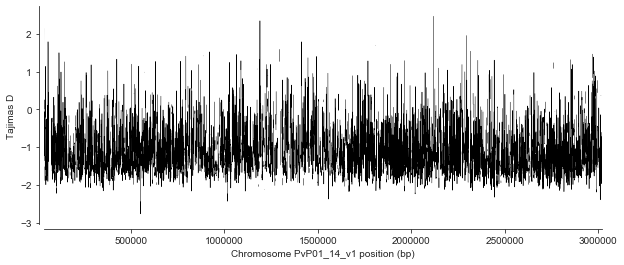

In [53]:
plot_window_D(pos_filt, ac)